# Game shares within each country – Battle Royale

This notebook recreates the **radial bar chart** from the Esports Genre Runner app.
For the genre **"Battle Royale"**, it shows for each country (top 28 by total earnings):

- that country's total esports earnings in this genre
- the *top game* in that country
- the **percentage of the country's earnings contributed by that top game**.

Data sources:
- `esports_games.csv` – master list of games with genre and total earnings
- `country_esports.csv` – country–game prize money breakdown


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Make plots appear inline if you're in Jupyter
%matplotlib inline

games_path = "esports_games.csv"
countries_path = "country_esports.csv"

games = pd.read_csv(games_path)
countries = pd.read_csv(countries_path)

games.head(), countries.head()


(                    Game  ReleaseDate     Genre  TotalEarnings  \
 0         Age of Empires         1997  Strategy      736284.75   
 1      Age of Empires II         1999  Strategy     3898508.73   
 2     Age of Empires III         2005  Strategy      122256.72   
 3      Age of Empires IV         2021  Strategy     1190813.44   
 4  Age of Empires Online         2011  Strategy       11462.98   
 
    OfflineEarnings  PercentOffline  TotalPlayers  TotalTournaments  
 0        522378.17        0.709478           624               341  
 1       1361409.22        0.349213          2256              1939  
 2         44472.60        0.363764           172               179  
 3        439117.93        0.368755           643               423  
 4           775.00        0.067609            52                68  ,
                     country  total_earnings  player_count               game  \
 0                     China    3.309117e+08          9333             Dota 2   
 1  United St

In [2]:
# Filter for a single genre
genre = "Battle Royale"
games_genre = games[games["Genre"] == genre].copy()

print(f"Number of games in {genre!r}:", len(games_genre))
games_genre[["Game", "TotalEarnings"]].head()


Number of games in 'Battle Royale': 17


,Game,TotalEarnings
632,Apex Legends,26153237.01
633,Apex Legends Mobile,0.00
634,Ark: Survival Of The Fittest,0.00
635,Fall Guys,340273.83
636,Farlight 84,0.00


In [3]:
# Build a set of game names in this genre
game_set = set(games_genre["Game"].str.strip())

# Keep only rows whose game is in this genre
countries_genre = countries[countries["game"].isin(game_set)].copy()
print("Rows in country_esports for this genre:", len(countries_genre))

countries_genre.head()


Rows in country_esports for this genre: 57


,country,total_earnings,player_count,game,game_earnings
1,United States of America,2.995845e+08,29198,Fortnite,52369833.18
9,Canada,5.050099e+07,4361,Fortnite,9174904.96
10,United Kingdom,4.975246e+07,5672,Fortnite,8783157.13
11,Japan,4.127952e+07,3982,PLAYERUNKNOWN'S BATTLEGROUNDS Mobile,5800971.79
20,Indonesia,2.174955e+07,2650,Free Fire,5106526.21


In [4]:
# For each country, find the game with the highest share of that country's prize pool
rows = []
for country, grp in countries_genre.groupby("country"):
    # total_earnings is constant per country in this file, so take the first value
    total = grp["total_earnings"].iloc[0]

    # Game with the largest game_earnings
    best = grp.loc[grp["game_earnings"].idxmax()]
    share = best["game_earnings"] / total if total > 0 else 0.0

    rows.append(
        {
            "country": country,
            "top_game": best["game"],
            "total_earnings": total,
            "game_earnings": best["game_earnings"],
            "share": share,
        }
    )

best_df = pd.DataFrame(rows)
best_df_sorted = best_df.sort_values("total_earnings", ascending=False).reset_index(drop=True)

# Keep the top 28 countries by total earnings, just like the app
top_n = 28
subset = best_df_sorted.head(top_n).copy()

subset.head()


,country,top_game,total_earnings,game_earnings,share
0,United States of America,Fortnite,2.995845e+08,52369833.18,0.174808
1,Canada,Fortnite,5.050099e+07,9174904.96,0.181678
2,United Kingdom,Fortnite,4.975246e+07,8783157.13,0.176537
3,Japan,PLAYERUNKNOWN'S BATTLEGROUNDS Mobile,4.127952e+07,5800971.79,0.140529
4,Indonesia,Free Fire,2.174955e+07,5106526.21,0.234788


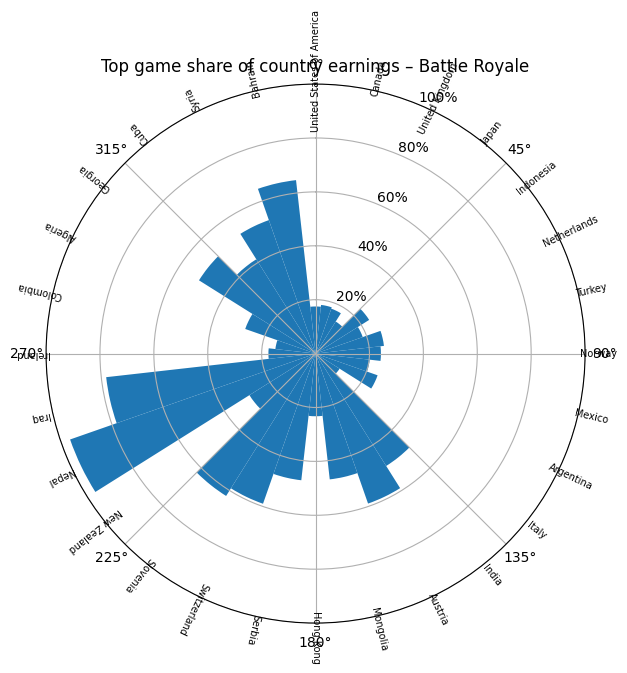

In [5]:
# Radial bar chart – top game share within each country (Battle Royale)

values = subset["share"].values               # between 0 and 1
countries_list = subset["country"].tolist()

N = len(values)
angles = np.linspace(0, 2 * np.pi, N, endpoint=False)

fig = plt.figure(figsize=(7, 7))
ax = plt.subplot(111, polar=True)

# Bars: one per country
width = 2 * np.pi / N
bars = ax.bar(angles, values, width=width, bottom=0.0)

# Make chart clockwise and start at 12 o'clock
ax.set_theta_direction(-1)
ax.set_theta_offset(np.pi / 2.0)

# Radial gridlines in percentage
ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_yticklabels(["20%", "40%", "60%", "80%", "100%"])
ax.set_ylim(0, 1.0)

# Country labels placed just outside the outer circle
for angle, country in zip(angles, countries_list):
    ax.text(
        angle,
        1.05,
        country,
        ha="center",
        va="center",
        fontsize=7,
        rotation=-np.degrees(angle) + 90,
    )

ax.set_title(
    "Top game share of country earnings – Battle Royale",
    va="bottom",
    fontsize=12,
)

plt.show()


### Reading the chart

- Each bar is **one country** (top 28 by total earnings in this genre).
- The **length** of a bar shows the percentage of that country's prize money that comes from its single top game.
- Bars near the outer circle (close to 100%) mean *one title dominates* that country's Battle Royale scene.
- Bars closer to the centre suggest the country's earnings are spread across several different Battle Royale games.